#### 06 · Bivariate analysis (pre-ML)

## Objective
Before modeling, we run a bivariate analysis to:
- Check the consistency of the selected features.
- Measure orthogonality (feature–feature dependencies) via a correlation matrix.
- Gauge the relationship with the target (direction/average strength, not causality).

We use **Spearman’s ρ** (rank correlations): more robust than Pearson to outliers, heavy tails, and monotone non-linear relationships.

---

## Feature set under review (ok list)
Screened across small ML tests (forward/GKFold, purged + embargo) and theory-driven: macro/sector to capture regime first, then micro/ticker to refine direction and timing.



In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
ROOT = Path(__file__).resolve().parents[0] if "__file__" in globals() else Path.cwd()
DATA_DIR = Path(os.getenv("DATA_DIR", ROOT / "data"))  
def p(file): return DATA_DIR / file

In [11]:
df_ml = pd.read_parquet(p('ML.parquet'))
ok2 = df_ml.select_dtypes('float64').columns.to_list()

In [12]:
ok = [
      "atr_10d_Tm1","vol_5d_Tm1","momentum_5d_Tm1","finroberta_compound",
    "opt_total_option_volume","volume_spike_Tm1","cumret_20d_Tm1","maxdd_20d_Tm1",
    "nlp_logit","nlp_margin","ev_fda_pos","ev_fda_neg","volume_5d","nlp_entropy",
    "IBB_ret_20d","finroberta_neg","opt_avg_iv_call_ln",
    "IBB_v_Tm1","spread_3m_10y","VIX_ma5_x","SPY_ma5",
    "HY_OAS_z","HY_OAS_chg_5d","slope_2s10s","DTWEXBGS","XBI_over_IBB_RS20", 
]

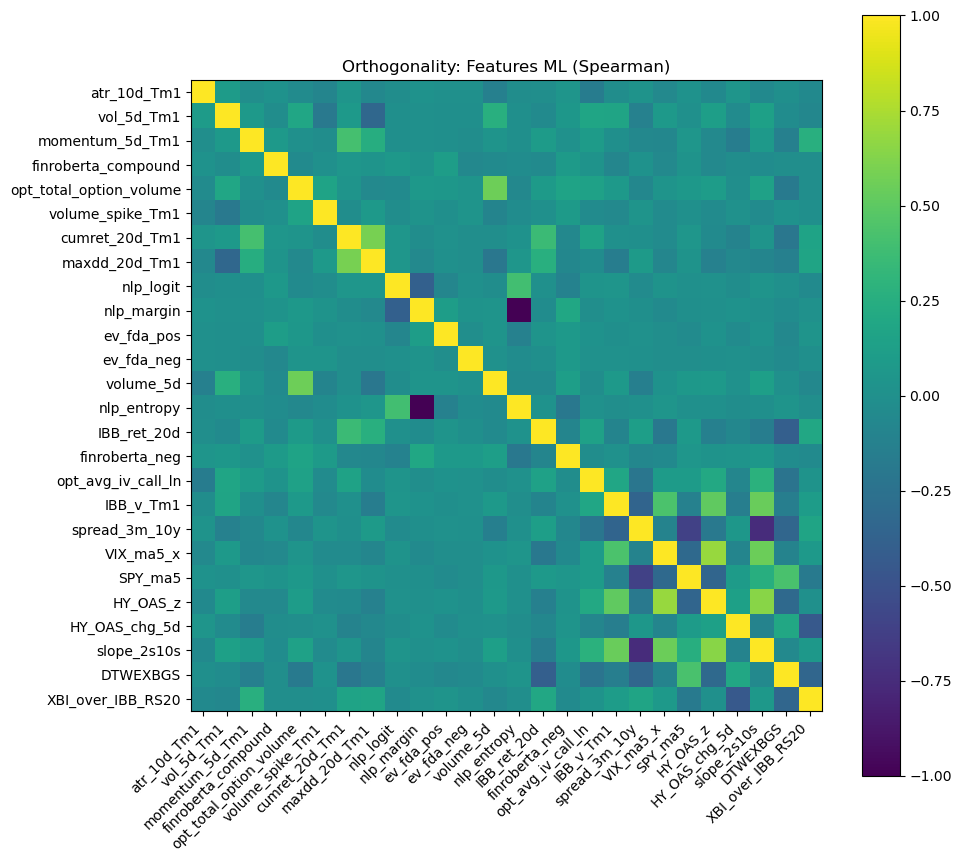

In [13]:
orth = df_ml[ok].corr(method="spearman")
plt.figure(figsize=(10, 9 ))
plt.imshow(orth, vmin=-1, vmax=1)
plt.xticks(range(len(ok)), ok, rotation=45, ha="right")
plt.yticks(range(len(ok)), ok)
plt.colorbar(); plt.title("Orthogonality: Features ML (Spearman)")
plt.tight_layout(); plt.show()


## Feature Orthogonality (Spearman Correlation)

The heatmap below shows the **pairwise Spearman correlations** between all ML input features.  
Diagonal = 1 (self-correlation). Off-diagonal values close to **0** indicate weak dependence, while values close to **±1** highlight redundancy or strong monotonic relationships.

### Key observations
- **Overall low to moderate correlations**: most feature pairs cluster around 0, suggesting good orthogonality and reduced multicollinearity.
- **High-correlation clusters**:
  - *Volume-related features* (e.g., `volume_5d`, `volume_spike_Tm1`, `opt_total_option_volume`) show localized positive correlations.
  - *NLP features* (`nlp_logit`, `nlp_margin`, `nlp_entropy`) are partially correlated, indicating they may capture overlapping text sentiment signals.
  - *Macro/credit spreads* (`spread_3m_10y`, `HY_OAS_Z`, `HY_OAS_chg_5d`) display some correlation, consistent with macro regime linkage.
- **Negative correlations**: sparse but present (dark purple tiles), mostly between technical momentum and defensive/macro variables.
- **Idiosyncratic orthogonality**: several features (e.g., `finroberta_neg`, `ev_fda_pos/neg`, `XBI_over_IBB_RS20`) are largely independent, providing unique signal contributions.

### Implications
- **Feature diversity**: The feature set is fairly well diversified, supporting model robustness by reducing risk of collinearity-driven overfitting.
- **Interpretability**: Localized correlations are economically intuitive (volume with volatility, macro spreads among themselves, NLP features clustered).
- **Next step**: consider feature selection or regularization (e.g., L1 penalty, permutation importance) to down-weight redundant clusters while retaining unique predictors.

---


In [14]:
ok.append('target_hit')

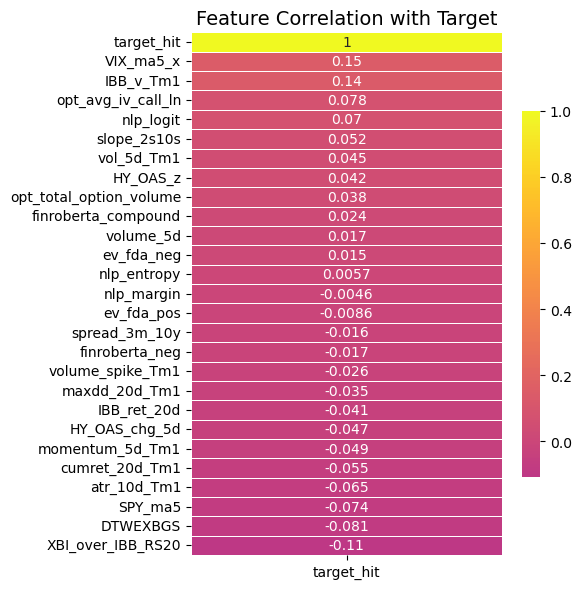

In [15]:
target_corr = df_ml[ok].corr(method = 'spearman')[['target_hit']].sort_values(by='target_hit', ascending=False)

plt.figure(figsize=(6, 6))  
sns.heatmap(
    target_corr, 
    annot=True, 
    cmap="plasma", 
    center=0, 
    linewidths=0.5, 
    cbar_kws={'shrink': 0.7}
)
plt.title("Feature Correlation with Target", fontsize=14)
plt.tight_layout()
plt.show()

# Spearman Feature Correlation with Target (`target_hit`)

### Positively correlated features
- **VIX_ma5_x**: 0.15 → the strongest positive correlation (higher short-term VIX tends to align with `target_hit`).
- **IBB_v_Tm1**: 0.14 → biotech volatility (IBB) also shows a notable positive relationship.
- **opt_avg_iv_call_ln**: 0.078 → option implied volatility (calls) has a mild positive correlation.
- **nlp_logit**: 0.07 → NLP sentiment logit adds a weak but positive signal.
- **slope_2s10s**: 0.052 → yield curve slope slightly aligns with target.

### Weakly correlated (close to zero)
- Features like **volume_5d**, **HY_OAS_z**, **nlp_entropy**, **finroberta_compound** show very small correlations (≈ 0.01–0.05).  
- These may contain signal but are weak individually → could combine with others in nonlinear models.

### Negatively correlated features
- **XBI_over_IBB_RS20**: -0.11 → strongest negative correlation; relative strength biotech vs. broader biotech index points inversely to target.
- **DTWEXBGS (USD index)**: -0.081 → stronger dollar tends to reduce probability of `target_hit`.
- **SPY_ma5**: -0.074 → short-term SPY momentum is slightly inversely related.
- **atr_10d_Tm1**: -0.065 → higher volatility (ATR) negatively associated.
- **cumret_20d_Tm1**: -0.055, **momentum_5d_Tm1**: -0.049 → past returns/momentum modestly inverse.

### Takeaways
- **No single feature dominates** (all |ρ| ≤ 0.15), confirming financial data is noisy.  
- A handful of features (VIX, IBB volatility, options IV) show the strongest positive link.  
- Currency strength, biotech relative strength, and short-term equity momentum act as **negative predictors**.  
- **Macro features (VIX, yield curve slope, USD index, spreads, OAS)** appear to be among the most correlated — suggesting the model could be **regime-dependent** and sensitive to broader market conditions.  
- This supports the need for **multivariate, non-linear models** (tree ensembles, ML methods) rather than relying on raw linear correlations.  

---
**Conclusion:** Spearman correlations highlight weak but meaningful signals. Most edges are small, so success depends on combining features and enforcing robust CV (purged + embargoed walk-forward) to avoid overfitting.

---


🚩 **Univariate summary.** We ran standard univariate diagnostics (AUC). Effects are **small** and mostly **regime-driven** (volatility/macro), consistent with weak-signal aggregation. To keep the narrative focused and avoid over-claiming, we **defer details** to the ML section.
**Top 4 features (up, AUC > 0.5)** — higher values associated with higher win odds:
1) **VIX_ma5_x** — AUC **0.5839**  
2) **IBB_v_Tm1** — AUC **0.5820**  
3) **opt_avg_iv_call_ln** — AUC **0.5438**  
4) **nlp_logit** — AUC **0.5404**

**Top 4 features (down, AUC < 0.5)** — inverse signals (helpful with flipped sign):
1) **XBI_over_IBB_RS20** — AUC **0.4379**  
2) **DTWEXBGS** — AUC **0.4533**  
3) **SPY_ma5** — AUC **0.4570**  
4) **atr_10d_Tm1** — AUC **0.4627**

